In [14]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# For evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
import joblib  # Use joblib to save scalers

# Detect if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seed for reproducibility
torch.manual_seed(42)


Using device: cpu


In [15]:
# Define the tickers and the date range
tickers = ['AAPL', 'MSFT', 'GOOG', 'META', 'AMZN']
start_date = '2019-01-01'
end_date = '2024-10-09'

# Download the data
data = yf.download(tickers, start=start_date, end=end_date)




[*********************100%***********************]  5 of 5 completed


In [16]:
data.head()

Price                      Adj Close                                    \
Ticker                          AAPL       AMZN       GOOG        META   
Date                                                                     
2019-01-02 00:00:00+00:00  37.750084  76.956497  52.164394  135.272705   
2019-01-03 00:00:00+00:00  33.989902  75.014000  50.678543  131.344543   
2019-01-04 00:00:00+00:00  35.440899  78.769501  53.404346  137.535904   
2019-01-07 00:00:00+00:00  35.362019  81.475502  53.288631  137.635590   
2019-01-08 00:00:00+00:00  36.036121  82.829002  53.682163  142.102158   

Price                                     Close                        \
Ticker                          MSFT       AAPL       AMZN       GOOG   
Date                                                                    
2019-01-02 00:00:00+00:00  95.501305  39.480000  76.956497  52.292500   
2019-01-03 00:00:00+00:00  91.988007  35.547501  75.014000  50.803001   
2019-01-04 00:00:00+00:00  96.266319  37.064999  78.769501  53.535500   
2019-01-07 00:00:00+00:00  96.389099  36.982498  81.475502  53.419498   
2019-01-08 00:00:00+00:00  97.087959  37.687500  82.829002  53.813999   

Price                                              ...       Open             \
Ticker                           META        MSFT  ...       AAPL       AMZN   
Date                                               ...                         
2019-01-02 00:00:00+00:00  135.679993  101.120003  ...  38.722500  73.260002   
2019-01-03 00:00:00+00:00  131.740005   97.400002  ...  35.994999  76.000504   
2019-01-04 00:00:00+00:00  137.949997  101.930000  ...  36.132500  76.500000   
2019-01-07 00:00:00+00:00  138.050003  102.059998  ...  37.174999  80.115501   
2019-01-08 00:00:00+00:00  142.529999  102.800003  ...  37.389999  83.234497   

Price                                                            Volume  \
Ticker                          GOOG        META        MSFT       AAPL   
Date                                                                      
2019-01-02 00:00:00+00:00  50.828499  128.990005   99.550003  148158800   
2019-01-03 00:00:00+00:00  52.049999  134.690002  100.099998  365248800   
2019-01-04 00:00:00+00:00  51.629501  134.009995   99.720001  234428400   
2019-01-07 00:00:00+00:00  53.575001  137.559998  101.639999  219111200   
2019-01-08 00:00:00+00:00  53.805500  139.889999  103.040001  164101200   

Price                                                               
Ticker                          AMZN      GOOG      META      MSFT  
Date                                                                
2019-01-02 00:00:00+00:00  159662000  30652000  28146200  35329300  
2019-01-03 00:00:00+00:00  139512000  36822000  22717900  42579100  
2019-01-04 00:00:00+00:00  183652000  41878000  29002100  44060600  
2019-01-07 00:00:00+00:00  159864000  39638000  20089300  35656100  
2019-01-08 00:00:00+00:00  177628000  35298000  26263800  31514400  

[5 rows x 30 columns]

In [17]:
# Check the data structure
print(data.info())

# Display the first few rows
print(data.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1452 entries, 2019-01-02 00:00:00+00:00 to 2024-10-08 00:00:00+00:00
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  1452 non-null   float64
 1   (Adj Close, AMZN)  1452 non-null   float64
 2   (Adj Close, GOOG)  1452 non-null   float64
 3   (Adj Close, META)  1452 non-null   float64
 4   (Adj Close, MSFT)  1452 non-null   float64
 5   (Close, AAPL)      1452 non-null   float64
 6   (Close, AMZN)      1452 non-null   float64
 7   (Close, GOOG)      1452 non-null   float64
 8   (Close, META)      1452 non-null   float64
 9   (Close, MSFT)      1452 non-null   float64
 10  (High, AAPL)       1452 non-null   float64
 11  (High, AMZN)       1452 non-null   float64
 12  (High, GOOG)       1452 non-null   float64
 13  (High, META)       1452 non-null   float64
 14  (High, MSFT)       1452 non-null   float64
 15  (Low, AAPL)        1452 

In [18]:
# Check for missing values
print(data.isnull().sum())




Price      Ticker
Adj Close  AAPL      0
           AMZN      0
           GOOG      0
           META      0
           MSFT      0
Close      AAPL      0
           AMZN      0
           GOOG      0
           META      0
           MSFT      0
High       AAPL      0
           AMZN      0
           GOOG      0
           META      0
           MSFT      0
Low        AAPL      0
           AMZN      0
           GOOG      0
           META      0
           MSFT      0
Open       AAPL      0
           AMZN      0
           GOOG      0
           META      0
           MSFT      0
Volume     AAPL      0
           AMZN      0
           GOOG      0
           META      0
           MSFT      0
dtype: int64


In [19]:
# prompt: How can I print the names of each column in the data in a list

column_names = data.columns.tolist()
print(column_names)


[('Adj Close', 'AAPL'), ('Adj Close', 'AMZN'), ('Adj Close', 'GOOG'), ('Adj Close', 'META'), ('Adj Close', 'MSFT'), ('Close', 'AAPL'), ('Close', 'AMZN'), ('Close', 'GOOG'), ('Close', 'META'), ('Close', 'MSFT'), ('High', 'AAPL'), ('High', 'AMZN'), ('High', 'GOOG'), ('High', 'META'), ('High', 'MSFT'), ('Low', 'AAPL'), ('Low', 'AMZN'), ('Low', 'GOOG'), ('Low', 'META'), ('Low', 'MSFT'), ('Open', 'AAPL'), ('Open', 'AMZN'), ('Open', 'GOOG'), ('Open', 'META'), ('Open', 'MSFT'), ('Volume', 'AAPL'), ('Volume', 'AMZN'), ('Volume', 'GOOG'), ('Volume', 'META'), ('Volume', 'MSFT')]


In [20]:
# Get descriptive statistics
print(data.describe())


Price     Adj Close                                                      \
Ticker         AAPL         AMZN         GOOG         META         MSFT   
count   1452.000000  1452.000000  1452.000000  1452.000000  1452.000000   
mean     131.390384   134.378938   106.858672   268.501471   255.460922   
std       51.324424    33.990899    35.626826   108.313659    93.335151   
min       33.989902    75.014000    50.678543    88.643105    91.988007   
25%       83.390030    98.145000    72.714174   185.568771   181.940639   
50%      141.991714   137.699501   106.656815   247.489838   250.369141   
75%      170.423325   164.338627   136.322727   326.813538   320.116371   
max      234.548523   200.000000   192.406723   595.940002   466.718781   

Price         Close                                                      ...  \
Ticker         AAPL         AMZN         GOOG         META         MSFT  ...   
count   1452.000000  1452.000000  1452.000000  1452.000000  1452.000000  ...   
mean     

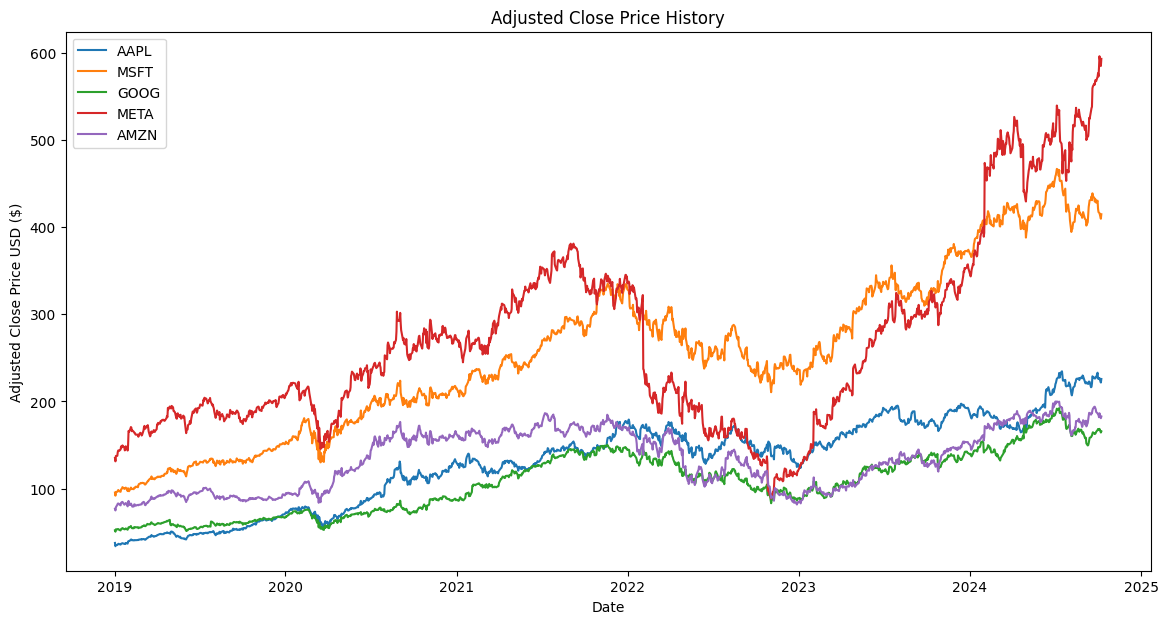

In [21]:
# Plot Adjusted Close prices
plt.figure(figsize=(14,7))
for ticker in tickers:
    plt.plot(data['Adj Close'][ticker], label=ticker)
plt.title('Adjusted Close Price History')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price USD ($)')
plt.legend()
plt.show()


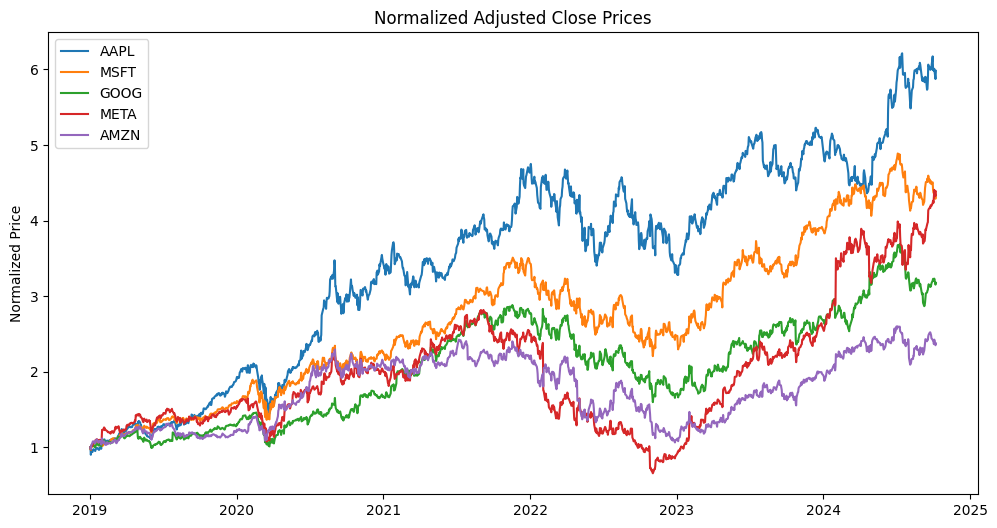

In [22]:
# Normalize the adjusted close prices for comparison
normalized_data = data['Adj Close'] / data['Adj Close'].iloc[0]

# Plot normalized prices
plt.figure(figsize=(12,6))
for ticker in tickers:
    plt.plot(normalized_data[ticker], label=ticker)
plt.title('Normalized Adjusted Close Prices')
plt.xlabel('')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()


In [23]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import joblib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn


# Detect if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seed for reproducibility
torch.manual_seed(42)



Using device: cpu


In [24]:
# Function to download data for a single ticker
def download_ticker_data(ticker, start_date, end_date, save_csv=False):
    """
    Downloads historical stock data for a given ticker symbol between specified dates.

    Args:
        ticker (str): Stock ticker symbol (e.g., 'AAPL' for Apple Inc.).
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        save_csv (bool): If True, saves the data to a CSV file named '{ticker}_data.csv'.

    Returns:
        pd.DataFrame: DataFrame containing the historical stock data.
    """
    df = yf.download(ticker, start=start_date, end=end_date)
    if save_csv:
        df.to_csv(f'{ticker}_data.csv')
    return df


# Define the list of tickers and date range
tickers = ['AAPL', 'GOOG', 'META', 'MSFT', 'AMZN']
start_date = '2019-01-01'
end_date = '2024-10-09'

# Dictionary to store data for each ticker
ticker_data = {}

# Download data for each ticker
for ticker in tickers:
    print(f"Downloading data for {ticker}...")
    df = download_ticker_data(ticker, start_date, end_date)
    ticker_data[ticker] = df


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

In [25]:
def add_technical_indicators(df):
    """
    Adds technical indicators to the stock data DataFrame.

    Indicators added:
        - Simple Moving Averages (SMA_20, SMA_50)
        - Exponential Moving Average (EMA_20)
        - Relative Strength Index (RSI)
        - Moving averages of Volume, High, Low, and Open prices

    Args:
        df (pd.DataFrame): DataFrame containing stock data with 'Adj Close', 'Volume', 'High', 'Low', 'Open' columns.

    Returns:
        pd.DataFrame: DataFrame with additional technical indicators.
    """
    df = df.copy()

    # Simple Moving Averages
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()

    # Exponential Moving Average
    df['EMA_20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()

    # Relative Strength Index (RSI)
    delta = df['Adj Close'].diff(1)
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    time_period = 14
    avg_gain = up.rolling(window=time_period, min_periods=time_period).mean()
    avg_loss = down.rolling(window=time_period, min_periods=time_period).mean()
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    df['RSI'] = rsi

    # Additional Moving Averages
    df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()
    df['High_MA_20'] = df['High'].rolling(window=20).mean()
    df['Low_MA_20'] = df['Low'].rolling(window=20).mean()
    df['Open_MA_20'] = df['Open'].rolling(window=20).mean()

    return df


# Apply technical indicators to each ticker
for ticker in tickers:
    print(f"Adding technical indicators to {ticker} data...")
    df = ticker_data[ticker]
    df = add_technical_indicators(df)
    df.dropna(inplace=True)  # Drop rows with NaN values resulting from indicator calculations
    ticker_data[ticker] = df


Adding technical indicators to AAPL data...
Adding technical indicators to GOOG data...
Adding technical indicators to META data...
Adding technical indicators to MSFT data...
Adding technical indicators to AMZN data...


In [26]:
def prepare_data(df, sequence_length=60, validation_split=0.2, test_split=0.1):
    """
    Prepares the data for LSTM modeling by scaling, creating sequences, and splitting into train, validation, and test sets.

    Args:
        df (pd.DataFrame): DataFrame containing stock data with technical indicators.
        sequence_length (int): Number of past days used for each prediction.
        validation_split (float): Fraction of data to be used for validation.
        test_split (float): Fraction of data to be used for testing.

    Returns:
        tuple: (X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler)
    """
    # Ensure 'Date' is datetime index
    df.index = pd.to_datetime(df.index)

    # Add date-related features
    df['Day'] = df.index.day
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Day_of_Week'] = df.index.dayofweek

    # Define features and target
    features = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
        'SMA_20', 'SMA_50', 'EMA_20', 'RSI',
        'Volume_MA_20', 'High_MA_20', 'Low_MA_20', 'Open_MA_20',
        'Day', 'Month', 'Year', 'Day_of_Week'
    ]
    target = 'Adj Close'

    # Drop rows with NaN values
    df.dropna(inplace=True)

    # Feature scaling
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(df[features])
    scaled_target = target_scaler.fit_transform(df[[target]])

    # Create sequences
    def create_sequences(features_data, target_data, seq_length):
        xs = []
        ys = []
        for i in range(len(features_data) - seq_length):
            x = features_data[i:(i + seq_length)]
            y = target_data[i + seq_length]  # Target is 'Adj Close' at next time step
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    X, y = create_sequences(scaled_features, scaled_target, sequence_length)

    # Split into training, validation, and test sets sequentially
    total_samples = len(X)
    test_size = int(test_split * total_samples)
    val_size = int(validation_split * total_samples)
    train_size = total_samples - val_size - test_size

    X_train = X[:train_size]
    y_train = y[:train_size]

    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]

    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]

    # Convert to PyTorch tensors and move to device
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    return X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler


In [27]:
# Define the LSTM model (unchanged)
class LSTMModel(nn.Module):
    """
    LSTM Model for time series prediction.

    Args:
        input_size (int): Number of input features.
        hidden_size (int): Number of features in the hidden state h.
        num_layers (int): Number of recurrent layers.
        output_size (int): Number of output features.
        dropout (float): Dropout probability.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layer with dropout between layers (if num_layers > 1)
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout
        )

        # Define dropout layer before fully connected layer
        self.dropout_layer = nn.Dropout(p=dropout)

        # Define output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass for LSTM model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_size).
        """
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Apply dropout after LSTM and before the fully connected layer
        out = self.dropout_layer(out[:, -1, :])

        # Get last time step output
        out = self.fc(out)
        return out


In [28]:
# import matplotlib.dates as mdates


# Directory to save models and associated files
model_dir = 'saved_models'

# Create the main 'saved_models' directory if it doesn't exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Loop over each ticker to prepare data, train, and evaluate the model
for ticker in tickers:
    print(f"\nProcessing ticker: {ticker}")

    # Get the data for this ticker
    df = ticker_data[ticker]

    # Prepare the data
    X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler = prepare_data(df)

    # # Define hyperparameters
    # input_size = X_train.shape[2]  # Number of features
    # hidden_size = 256
    # num_layers = 2
    # output_size = 1
    # num_epochs = 400
    # learning_rate = 0.0001
    # dropout = 0.2
    # patience = 250  # For early stopping

    # Define hyperparameters
    input_size = X_train.shape[2]  # Number of features
    hidden_size = 128
    num_layers = 2
    output_size = 1
    num_epochs = 300
    learning_rate = 0.0001
    dropout = 0.2
    patience = 200  # For early stopping


    # Initialize the model, loss function, and optimizer
    model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early Stopping Initialization
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Initialize lists to store loss values for this ticker
    train_loss_values = []
    val_loss_values = []

    # Training loop with validation
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        train_loss_values.append(train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val.view(-1, 1)).item()
            val_loss_values.append(val_loss)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model state
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Create a subdirectory for the current ticker
    ticker_dir = os.path.join(model_dir, ticker)
    plots_dir = os.path.join(ticker_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)  # Create 'plots' subdirectory

    # Save the trained model
    model_path = os.path.join(ticker_dir, 'model.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save the scalers
    scaler_path = os.path.join(ticker_dir, 'scalers.pkl')
    with open(scaler_path, 'wb') as f:
        joblib.dump({
            'feature_scaler': feature_scaler,
            'target_scaler': target_scaler
        }, f)
    print(f"Scalers saved to {scaler_path}")

    # Save training and validation loss values for future analysis
    loss_values_path = os.path.join(ticker_dir, 'loss_values.npy')
    np.save(loss_values_path, np.array([train_loss_values, val_loss_values]))
    print(f"Loss values saved to {loss_values_path}")

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label='Training Loss')
    plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss')
    plt.title(f'{ticker} Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plot_path = os.path.join(plots_dir, 'train_val_loss.png')
    plt.savefig(plot_path)
    plt.close()
    print(f"Training and Validation loss plot saved to {plot_path}")

    # Evaluation on Test Set
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    # Convert predictions and actual values to NumPy arrays
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # Inverse transform the predictions and actual values
    y_pred_inversed = target_scaler.inverse_transform(y_pred_np)
    y_test_inversed = target_scaler.inverse_transform(y_test_np)

    # Flatten the arrays
    y_pred_inversed = y_pred_inversed.flatten()
    y_test_inversed = y_test_inversed.flatten()

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test_inversed, y_pred_inversed))
    mae = mean_absolute_error(y_test_inversed, y_pred_inversed)
    r2 = r2_score(y_test_inversed, y_pred_inversed)

    # Calculate SMAPE
    def smape(A, F):
        """
        Calculates Symmetric Mean Absolute Percentage Error.
        """
        return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F) + 1e-8))

    smape_value = smape(y_test_inversed, y_pred_inversed)

    # Calculate Directional Accuracy
    direction_actual = np.sign(y_test_inversed[1:] - y_test_inversed[:-1])
    direction_predicted = np.sign(y_pred_inversed[1:] - y_pred_inversed[:-1])
    directional_accuracy = np.mean(direction_actual == direction_predicted) * 100

    # Print performance metrics
    print(f'{ticker} - RMSE: {rmse:.2f}')
    print(f'{ticker} - MAE: {mae:.2f}')
    print(f'{ticker} - R-squared: {r2:.4f}')
    print(f'{ticker} - SMAPE: {smape_value:.2f}%')
    print(f'{ticker} - Directional Accuracy: {directional_accuracy:.2f}%')

    # Save performance metrics
    metrics_path = os.path.join(ticker_dir, 'metrics.txt')
    with open(metrics_path, 'w') as f:
        f.write(f'RMSE: {rmse:.2f}\n')
        f.write(f'MAE: {mae:.2f}\n')
        f.write(f'R-squared: {r2:.4f}\n')
        f.write(f'SMAPE: {smape_value:.2f}%\n')
        f.write(f'Directional Accuracy: {directional_accuracy:.2f}%\n')
    print(f"Metrics saved to {metrics_path}")

    # 1. Residuals vs. Predicted Values
    residuals = y_test_inversed - y_pred_inversed
    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred_inversed, residuals, alpha=0.5)
    plt.hlines(y=0, xmin=min(y_pred_inversed), xmax=max(y_pred_inversed), colors='red')
    plt.title(f'{ticker} Residuals vs. Predicted Values')
    plt.xlabel('Predicted Prices')
    plt.ylabel('Residuals')
    plot_path = os.path.join(plots_dir, 'residuals_vs_predicted.png')
    plt.savefig(plot_path)
    plt.close()
    print(f"Residuals vs. Predicted Values plot saved to {plot_path}")

    # 2. Histogram of Residuals
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.title(f'{ticker} Residuals Distribution')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plot_path = os.path.join(plots_dir, 'residuals_histogram.png')
    plt.savefig(plot_path)
    plt.close()
    print(f"Residuals histogram saved to {plot_path}")

    # 3. Actual vs. Predicted Prices
    # plt.figure(figsize=(14, 7))
    # plt.plot(y_test_inversed, label='Actual Price')
    # plt.plot(y_pred_inversed, label='Predicted Price')
    # plt.title(f'{ticker} Stock Price Prediction')
    # plt.xlabel('Days')
    # plt.ylabel('Price USD ($)')
    # plt.legend()
    # plot_path = os.path.join(plots_dir, 'actual_vs_predicted.png')
    # plt.savefig(plot_path)
    # plt.close()
    # print(f"Actual vs. Predicted Prices plot saved to {plot_path}")

    # Define the start date of your test set
    start_date = pd.to_datetime('2024-04-01')  # Replace with your actual start date

    # Create a date range (assuming business days; adjust frequency as needed)
    dates = pd.date_range(start=start_date, periods=len(y_test_inversed), freq='B')

    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_test_inversed, label='Actual Price')
    plt.plot(dates, y_pred_inversed, label='Predicted Price')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('')
    plt.ylabel('Price USD ($)')
    plt.legend()

    # Rotate the x-axis labels by 45 degrees and align them to the right
    plt.xticks(rotation=45, ha='right')

    # Optional: Improve date formatting using matplotlib.dates
    # Uncomment the following lines if you want better date formatting
    # ax = plt.gca()
    # date_format = mdates.DateFormatter('%Y-%m-%d')  # Customize the date format as needed
    # ax.xaxis.set_major_formatter(date_format)
    # locator = mdates.AutoDateLocator()
    # ax.xaxis.set_major_locator(locator)

    plt.tight_layout()  # Adjust the layout to prevent clipping of tick-labels
    plot_path = os.path.join(plots_dir, 'actual_vs_predicted.png')
    plt.savefig(plot_path)
    plt.close()
    print(f"Actual vs. Predicted Prices plot saved to {plot_path}")



Processing ticker: AAPL
Epoch [5/300], Train Loss: 0.1844, Val Loss: 0.4715
Epoch [10/300], Train Loss: 0.1624, Val Loss: 0.4250
Epoch [15/300], Train Loss: 0.1412, Val Loss: 0.3790
Epoch [20/300], Train Loss: 0.1211, Val Loss: 0.3317
Epoch [25/300], Train Loss: 0.0993, Val Loss: 0.2817
Epoch [30/300], Train Loss: 0.0777, Val Loss: 0.2277
Epoch [35/300], Train Loss: 0.0558, Val Loss: 0.1691
Epoch [40/300], Train Loss: 0.0350, Val Loss: 0.1073
Epoch [45/300], Train Loss: 0.0191, Val Loss: 0.0491
Epoch [50/300], Train Loss: 0.0110, Val Loss: 0.0103
Epoch [55/300], Train Loss: 0.0139, Val Loss: 0.0011
Epoch [60/300], Train Loss: 0.0127, Val Loss: 0.0018
Epoch [65/300], Train Loss: 0.0092, Val Loss: 0.0079
Epoch [70/300], Train Loss: 0.0086, Val Loss: 0.0138
Epoch [75/300], Train Loss: 0.0082, Val Loss: 0.0131
Epoch [80/300], Train Loss: 0.0076, Val Loss: 0.0077
Epoch [85/300], Train Loss: 0.0059, Val Loss: 0.0028
Epoch [90/300], Train Loss: 0.0054, Val Loss: 0.0012
Epoch [95/300], Train 

In [29]:
def load_model_and_scalers(ticker, model_dir='saved_models'):
    """
    Loads the trained LSTM model and associated scalers for a given ticker.

    Args:
        ticker (str): Stock ticker symbol (e.g., 'AAPL').
        model_dir (str): Path to the directory where models are saved.

    Returns:
        tuple: A tuple containing the loaded model, feature scaler, and target scaler.
               (model, feature_scaler, target_scaler)

    Raises:
        FileNotFoundError: If the model or scaler files are not found.
        Exception: For any other exceptions during loading.
    """
    # Construct the path to the ticker's subdirectory
    ticker_dir = os.path.join(model_dir, ticker)

    # Define paths to the model and scaler files
    model_path = os.path.join(ticker_dir, 'model.pth')
    scaler_path = os.path.join(ticker_dir, 'scalers.pkl')

    # Check if the ticker's directory exists
    if not os.path.isdir(ticker_dir):
        raise FileNotFoundError(f"Directory for ticker '{ticker}' does not exist at {ticker_dir}.")

    # Check if the model file exists
    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"Model file not found for ticker '{ticker}' at {model_path}.")

    # Check if the scaler file exists
    if not os.path.isfile(scaler_path):
        raise FileNotFoundError(f"Scaler file not found for ticker '{ticker}' at {scaler_path}.")

    # Load scalers
    try:
        with open(scaler_path, 'rb') as f:
            scalers = joblib.load(f)
        feature_scaler = scalers['feature_scaler']
        target_scaler = scalers['target_scaler']
    except Exception as e:
        raise Exception(f"Error loading scalers for ticker '{ticker}': {e}")

    # Initialize the model with the correct input size
    input_size = len(feature_scaler.scale_)
    hidden_size = 128
    num_layers = 2
    output_size = 1
    dropout = 0.2

    model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)

    # Load the model state
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        print(f"Model for '{ticker}' loaded successfully from {model_path}.")
    except Exception as e:
        raise Exception(f"Error loading model for ticker '{ticker}': {e}")

    return model, feature_scaler, target_scaler

In [30]:
def predict_future_prices(ticker, query_dates, model, feature_scaler, target_scaler, recent_data, sequence_length=60):
    """
    Predict future Adjusted Close prices for a given ticker and list of dates.

    Args:
        ticker (str): Stock ticker symbol.
        query_dates (list): List of dates as strings (e.g., ['2024-10-01', '2024-10-02']).
        model (nn.Module): Trained LSTM model.
        feature_scaler (MinMaxScaler): Scaler used for feature scaling.
        target_scaler (MinMaxScaler): Scaler used for target scaling.
        recent_data (pd.DataFrame): DataFrame containing historical data up to the day before predictions.
        sequence_length (int): Number of past days used for each prediction.

    Returns:
        dict: Dictionary with dates as keys and dictionaries containing predicted price,
              actual price (if available), and error percentage.
    """
    # Convert query_dates to datetime objects
    query_dates = [pd.to_datetime(date) for date in query_dates]

    # Filter out non-trading days (weekends)
    trading_days = [date for date in query_dates if date.weekday() < 5]

    if not trading_days:
        print("No trading days in the provided query dates.")
        return {}

    # Prepare date range for fetching actual data
    start_date = (trading_days[0] - timedelta(days=sequence_length + 50)).strftime('%Y-%m-%d')
    end_date = (trading_days[-1] + timedelta(days=1)).strftime('%Y-%m-%d')  # Include the last day

    # Fetch actual data for technical indicators and comparison
    actual_data = yf.download(ticker, start=start_date, end=end_date)

    # Ensure recent_data includes up to the day before the first prediction date
    last_sequence_date = trading_days[0] - timedelta(days=1)
    if last_sequence_date > recent_data.index[-1]:
        # Fetch additional data if needed
        additional_data = yf.download(
            ticker,
            start=(recent_data.index[-1] + timedelta(days=1)).strftime('%Y-%m-%d'),
            end=(last_sequence_date + timedelta(days=1)).strftime('%Y-%m-%d')
        )
        if not additional_data.empty:
            recent_data = pd.concat([recent_data, additional_data])
            recent_data.sort_index(inplace=True)
            print(f"Fetched additional data for {ticker} up to {last_sequence_date.strftime('%Y-%m-%d')}")

    # Add technical indicators to recent_data
    recent_data = add_technical_indicators(recent_data)
    recent_data.dropna(inplace=True)

    # Initialize predictions dictionary
    predictions = {}

    # Features to be used
    features = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
        'SMA_20', 'SMA_50', 'EMA_20', 'RSI',
        'Volume_MA_20', 'High_MA_20', 'Low_MA_20', 'Open_MA_20',
        'Day', 'Month', 'Year', 'Day_of_Week'
    ]

    # Initialize last_sequence with recent_data
    last_sequence = recent_data.copy(deep=True)

    for date in trading_days:
        date_str = date.strftime('%Y-%m-%d')
        print(f"\nPredicting for {ticker} on {date_str}")

        # Prepare the input sequence without the new row
        temp_sequence = last_sequence[-sequence_length:].copy()

        # Add date-related features
        temp_sequence.loc[:, 'Day'] = temp_sequence.index.day
        temp_sequence.loc[:, 'Month'] = temp_sequence.index.month
        temp_sequence.loc[:, 'Year'] = temp_sequence.index.year
        temp_sequence.loc[:, 'Day_of_Week'] = temp_sequence.index.dayofweek

        # Fill any missing values
        # temp_sequence = temp_sequence.ffill().bfill()
        temp_sequence = temp_sequence.ffill().bfill()


        # Prepare input features
        X_input = temp_sequence[features].values

        # Scale features
        scaled_features = feature_scaler.transform(X_input)

        # Ensure input shape is correct
        X_input_tensor = torch.tensor(scaled_features.reshape(1, sequence_length, -1), dtype=torch.float32).to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            y_pred = model(X_input_tensor)

        # Inverse transform prediction
        y_pred_inversed = target_scaler.inverse_transform(y_pred.cpu().numpy())

        predicted_adj_close = y_pred_inversed.flatten()[0]
        print(f"Predicted Adjusted Close: ${predicted_adj_close:.2f}")

        # Get actual Adj Close if available
        if date in actual_data.index:
            actual_adj_close = actual_data.at[date, 'Adj Close']
            error_pct = ((predicted_adj_close - actual_adj_close) / actual_adj_close) * 100
            print(f"Actual Adjusted Close: ${actual_adj_close:.2f}, Error: {error_pct:.2f}%")
        else:
            actual_adj_close = None
            error_pct = None
            print(f"Actual Adjusted Close not available for {date_str}")

        # Store prediction
        predictions[date_str] = {
            'Predicted Price': predicted_adj_close,
            'Actual Price': actual_adj_close,
            'Error Percentage': error_pct
        }

        # Now, create new_row for the date
        new_row = pd.DataFrame(index=[date], columns=recent_data.columns)

        # Estimate features for the new date
        n_days = 20  # Window for rolling means

        # Use actual data if available
        if date in actual_data.index:
            actual_row = actual_data.loc[date]
            for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
                new_row.at[date, col] = actual_row[col]
            print(f"Used actual market data for {date_str}")
        else:
            # Estimate using rolling means
            for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
                new_row.at[date, col] = last_sequence[col].iloc[-n_days:].mean()
            print(f"Estimated market data for {date_str} using rolling means")

        # Set 'Adj Close' in new_row to actual or predicted value
        new_adj_close = actual_adj_close if actual_adj_close is not None else predicted_adj_close
        new_row.at[date, 'Adj Close'] = new_adj_close
        print(f"Set 'Adj Close' for {date_str} to {new_adj_close}")

        # Append new_row to last_sequence
        last_sequence = pd.concat([last_sequence, new_row])

        # Recalculate technical indicators on last_sequence
        last_sequence = add_technical_indicators(last_sequence)

        # Fill any missing values in last_sequence
        last_sequence = last_sequence.ffill().bfill()

    return predictions


In [31]:
def predict_future_prices_multiple_tickers(tickers, query_dates, models_info, ticker_data, sequence_length=60):
    """
    Predict future Adjusted Close prices for multiple tickers.

    Args:
        tickers (list): List of stock ticker symbols.
        query_dates (list): List of dates as strings for prediction.
        models_info (dict): Dictionary with ticker symbols as keys and a dictionary containing 'model',
                            'feature_scaler', and 'target_scaler' as values.
        ticker_data (dict): Dictionary with ticker symbols as keys and their corresponding historical DataFrames.
        sequence_length (int): Number of past days used for each prediction.

    Returns:
        dict: Dictionary with ticker symbols as keys and their prediction dictionaries as values.
    """
    all_predictions = {}

    for ticker in tickers:
        print(f"\nPredicting future prices for {ticker}...")
        if ticker not in models_info:
            print(f"No model information found for {ticker}. Skipping.")
            continue

        model_info = models_info[ticker]
        model = model_info['model']
        feature_scaler = model_info['feature_scaler']
        target_scaler = model_info['target_scaler']
        recent_data = ticker_data[ticker]

        predictions = predict_future_prices(
            ticker,
            query_dates,
            model,
            feature_scaler,
            target_scaler,
            recent_data,
            sequence_length
        )
        all_predictions[ticker] = predictions

    return all_predictions


In [32]:
# Define the last date in your training data
last_trained_date = datetime.strptime(end_date, '%Y-%m-%d')

# Define how many days ahead you want to predict
num_days_ahead = 7  # Predict the next 7 trading days

# Generate future dates (weekdays only)
future_dates = []
current_date = last_trained_date + timedelta(days=1)
while len(future_dates) < num_days_ahead:
    if current_date.weekday() < 5:  # Monday=0, Sunday=6
        future_dates.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=1)

print(f"Dates for Prediction: {future_dates}")

Dates for Prediction: ['2024-10-10', '2024-10-11', '2024-10-14', '2024-10-15', '2024-10-16', '2024-10-17', '2024-10-18']


In [33]:

# Define tickers and their corresponding data
tickers_to_predict = ['AAPL', 'GOOG', 'META', 'MSFT', 'AMZN']  # Add 'META' as per your example
query_dates = future_dates  # From the previous step

# Dictionary to store loaded models and scalers
loaded_models = {}

# Load models and scalers for each ticker
for ticker in tickers_to_predict:
    print(f"\nLoading model and scalers for {ticker}...")
    try:
        model, feature_scaler, target_scaler = load_model_and_scalers(ticker)
        loaded_models[ticker] = {
            'model': model,
            'feature_scaler': feature_scaler,
            'target_scaler': target_scaler
        }
        print(f"Model and scalers for {ticker} loaded successfully.")
    except Exception as e:
        print(f"Failed to load model for {ticker}: {e}")

# Make predictions for all tickers
all_predictions = predict_future_prices_multiple_tickers(
    tickers_to_predict,
    future_dates,
    loaded_models,
    ticker_data,
    sequence_length=60
)

# Display predictions
for ticker, predictions in all_predictions.items():
    print(f"\nPredictions for {ticker}:")
    for date, info in predictions.items():
        predicted_price = info['Predicted Price']
        actual_price = info.get('Actual Price')
        error_pct = info.get('Error Percentage')

        if actual_price is not None:
            print(f"Date: {date}, Predicted: ${predicted_price:.2f}, Actual: ${actual_price:.2f}, Error: {error_pct:.2f}%")
        else:
            print(f"Date: {date}, Predicted: ${predicted_price:.2f}, Actual: N/A")


Loading model and scalers for AAPL...
Model for 'AAPL' loaded successfully from saved_models/AAPL/model.pth.
Model and scalers for AAPL loaded successfully.

Loading model and scalers for GOOG...
Model for 'GOOG' loaded successfully from saved_models/GOOG/model.pth.
Model and scalers for GOOG loaded successfully.

Loading model and scalers for META...
Model for 'META' loaded successfully from saved_models/META/model.pth.
Model and scalers for META loaded successfully.

Loading model and scalers for MSFT...
Model for 'MSFT' loaded successfully from saved_models/MSFT/model.pth.
Model and scalers for MSFT loaded successfully.

Loading model and scalers for AMZN...
Model for 'AMZN' loaded successfully from saved_models/AMZN/model.pth.
Model and scalers for AMZN loaded successfully.

Predicting future prices for AAPL...


/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97460/968508645.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

Fetched additional data for AAPL up to 2024-10-09

Predicting for AAPL on 2024-10-10
Predicted Adjusted Close: $223.21
Actual Adjusted Close: $229.04, Error: -2.55%
Used actual market data for 2024-10-10
Set 'Adj Close' for 2024-10-10 to 229.0399932861328

Predicting for AAPL on 2024-10-11
Predicted Adjusted Close: $223.33
Actual Adjusted Close not available for 2024-10-11
Estimated market data for 2024-10-11 using rolling means
Set 'Adj Close' for 2024-10-11 to 223.33444213867188

Predicting for AAPL on 2024-10-14
Predicted Adjusted Close: $223.55
Actual Adjusted Close not available for 2024-10-14
Estimated market data for 2024-10-14 using rolling means
Set 'Adj Close' for 2024-10-14 to 223.54640197753906

Predicting for AAPL on 2024-10-15
Predicted Adjusted Close: $223.10
Actual Adjusted Close not available for 2024-10-15
Estimated market data for 2024-10-15 using rolling means
Set 'Adj Close' for 2024-10-15 to 223.10047912597656

Predicting for AAPL on 2024-10-16
Predicted Adjusted 


/Users/RobertHolzmann/Downloads/lstm_stock_predictor/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97460/1791676185.py:146: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  last_sequence = pd.concat([last_sequence, new_row])
/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97460/1791676185.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tru

Fetched additional data for GOOG up to 2024-10-09

Predicting for GOOG on 2024-10-10
Predicted Adjusted Close: $172.89
Actual Adjusted Close: $163.18, Error: 5.95%
Used actual market data for 2024-10-10
Set 'Adj Close' for 2024-10-10 to 163.17999267578125

Predicting for GOOG on 2024-10-11
Predicted Adjusted Close: $172.66
Actual Adjusted Close not available for 2024-10-11
Estimated market data for 2024-10-11 using rolling means
Set 'Adj Close' for 2024-10-11 to 172.6609649658203

Predicting for GOOG on 2024-10-14
Predicted Adjusted Close: $172.73
Actual Adjusted Close not available for 2024-10-14
Estimated market data for 2024-10-14 using rolling means
Set 'Adj Close' for 2024-10-14 to 172.7295379638672

Predicting for GOOG on 2024-10-15
Predicted Adjusted Close: $172.56
Actual Adjusted Close not available for 2024-10-15
Estimated market data for 2024-10-15 using rolling means
Set 'Adj Close' for 2024-10-15 to 172.55862426757812

Predicting for GOOG on 2024-10-16
Predicted Adjusted Cl

/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97460/1791676185.py:146: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  last_sequence = pd.concat([last_sequence, new_row])
/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97460/1791676185.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  last_sequence = last_sequence.ffill().bfill()
/Users/RobertHolzmann/Downloads/lstm_stock_predictor/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxSca

Predicted Adjusted Close: $614.52
Actual Adjusted Close: $583.83, Error: 5.26%
Used actual market data for 2024-10-10
Set 'Adj Close' for 2024-10-10 to 583.8300170898438

Predicting for META on 2024-10-11
Predicted Adjusted Close: $616.10
Actual Adjusted Close not available for 2024-10-11
Estimated market data for 2024-10-11 using rolling means
Set 'Adj Close' for 2024-10-11 to 616.0964965820312

Predicting for META on 2024-10-14
Predicted Adjusted Close: $617.80
Actual Adjusted Close not available for 2024-10-14
Estimated market data for 2024-10-14 using rolling means
Set 'Adj Close' for 2024-10-14 to 617.7998657226562

Predicting for META on 2024-10-15
Predicted Adjusted Close: $618.91
Actual Adjusted Close not available for 2024-10-15
Estimated market data for 2024-10-15 using rolling means
Set 'Adj Close' for 2024-10-15 to 618.907958984375

Predicting for META on 2024-10-16
Predicted Adjusted Close: $620.34
Actual Adjusted Close not available for 2024-10-16
Estimated market data fo

[*********************100%***********************]  1 of 1 completed
/Users/RobertHolzmann/Downloads/lstm_stock_predictor/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97460/1791676185.py:146: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  last_sequence = pd.concat([last_sequence, new_row])
/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97460/1791676185.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the fut

Fetched additional data for MSFT up to 2024-10-09

Predicting for MSFT on 2024-10-10
Predicted Adjusted Close: $429.32
Actual Adjusted Close: $415.84, Error: 3.24%
Used actual market data for 2024-10-10
Set 'Adj Close' for 2024-10-10 to 415.8399963378906

Predicting for MSFT on 2024-10-11
Predicted Adjusted Close: $427.60
Actual Adjusted Close not available for 2024-10-11
Estimated market data for 2024-10-11 using rolling means
Set 'Adj Close' for 2024-10-11 to 427.6004638671875

Predicting for MSFT on 2024-10-14
Predicted Adjusted Close: $426.75
Actual Adjusted Close not available for 2024-10-14
Estimated market data for 2024-10-14 using rolling means
Set 'Adj Close' for 2024-10-14 to 426.75311279296875

Predicting for MSFT on 2024-10-15
Predicted Adjusted Close: $426.93
Actual Adjusted Close not available for 2024-10-15
Estimated market data for 2024-10-15 using rolling means
Set 'Adj Close' for 2024-10-15 to 426.9295349121094

Predicting for MSFT on 2024-10-16
Predicted Adjusted Clo

/Users/RobertHolzmann/Downloads/lstm_stock_predictor/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97460/1791676185.py:146: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  last_sequence = pd.concat([last_sequence, new_row])
/var/folders/ww/g22rd79j2xgfxy8trypcnk200000gn/T/ipykernel_97460/1791676185.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True